https://x.com/nicorioscenteno/status/1621655101164118017

Agenda:

- Modelo para una marca con beta0 fijo
- Modelo para una marca con beta0 variable
- Modelo para todas las marcas con beta0 variable
- Modelo para todas las marcas con parametros jerarquicos (¿tambien para beta0?)

In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm

## Datos

In [ ]:
tiempo = np.array([0, 180, 320, 500]) / 60

datos = {
    "stanley": np.array([80.0, 70.0, 65.0, 60.0]),
    "lumilagro": np.array([75.0, 65.0, 60.0, 55.0]),
    "aluminio": np.array([80.0, 62.5, 57.5, 50.0]),
    "rosa": np.array([80.0, 47.5, 37.5, 30.0])
}

In [ ]:
fig, ax = plt.subplots()


for i, (marca, temperaturas) in enumerate(datos.items()):
    ax.plot(tiempo, temperaturas, color=f"C{i}", label=marca)

ax.legend(title="Marca")
ax.set(xlabel="Tiempo (horas)", ylabel="Temperatura (grados centígrados)");

fig, ax = plt.subplots()


for i, (marca, temperaturas) in enumerate(datos.items()):
    ax.plot(tiempo, temperaturas, color=f"C{i}", label=marca)

ax.legend(title="Marca")
ax.set(xlabel="Tiempo (horas)", ylabel="Temperatura (grados centígrados)");

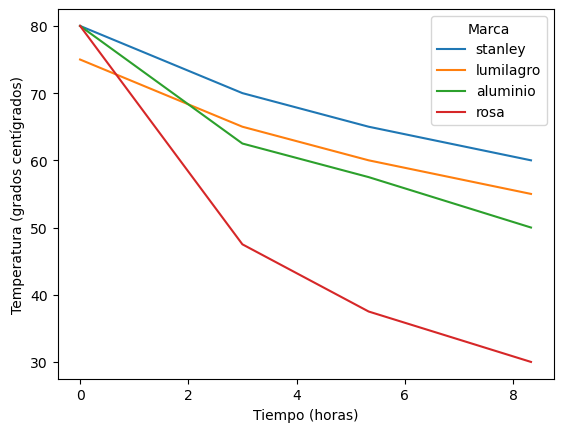

$$
\frac{\text{d}T(t)}{\text{d}t} = r [T_{\text{amb}} - T(t)]
$$

$$
T(t) = T_{\text{amb}} + (T_i - T_{\text{amb}})e^{-rt}
$$

$$
T(t) - T_{\text{amb}} = T_{\text{diff}} \cdot e^{-rt}
$$

$$
\begin{aligned}
\log(T(t) - T_\text{amb}) &= \log(T_\text{diff} \times e^{-rt}) \\
&= \log(T_\text{diff}) - rt \\
&= \alpha - \beta \times t
\end{aligned}
$$

$$
\log(T_\text{diff}) = \log(T_\text{inicial} - T_\text{ambiente}) = \log(80 - 25) = \log(55) \approx 4 \\
$$

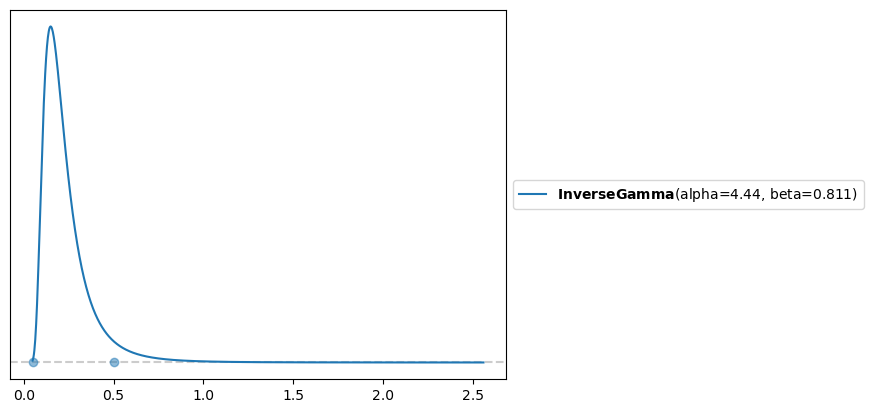

In [14]:
pz.maxent(pz.InverseGamma(), lower=0.05, upper=0.5, mass=0.95);

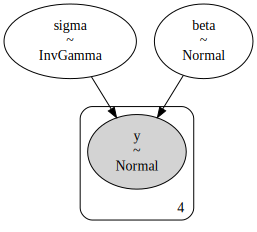

In [93]:
t_ambiente = 24
y_stanley = np.log(datos["stanley"] - t_ambiente)


with pm.Model() as model:
    #alpha = pm.Normal("alpha", mu=4, sigma=0.025)
    alpha = np.log(80 - 24)
    beta = pm.Normal("beta", mu=0, sigma=0.1)
    mu = alpha - beta * tiempo
    sigma = pm.InverseGamma("sigma", alpha=4.5, beta=0.8)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y_stanley)

model.to_graphviz()

In [94]:
with model:
    idata = pm.sample(tune=2000, target_accept=0.99, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


In [95]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.055,0.013,0.033,0.080,0.000,0.001,1559.0,1127.0,1.0
sigma,0.124,0.054,0.050,0.214,0.002,0.004,1212.0,1408.0,1.0


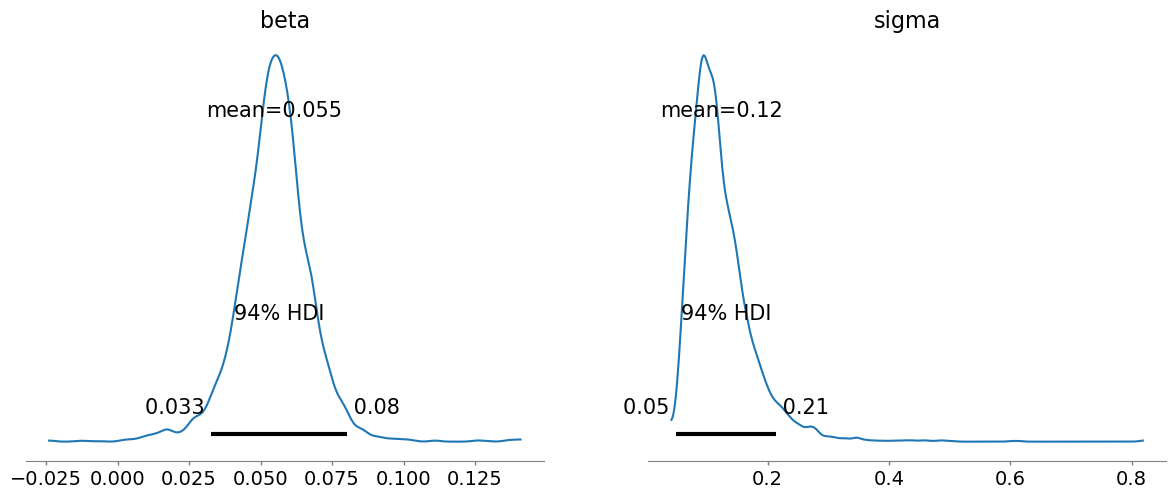

In [96]:
az.plot_posterior(idata);

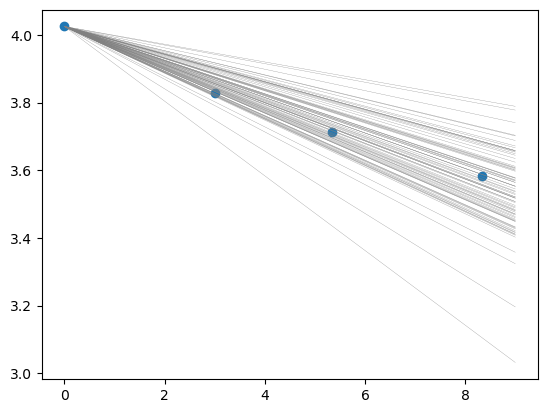

In [98]:
fig, ax = plt.subplots()

t_grid = np.linspace(0, 9, num=100)
betas = idata.posterior["beta"].values.flatten()[::50]
#alphas = idata.posterior["alpha"].values.flatten()[::50]
alphas = np.ones_like(betas) * np.log(80 - t_ambiente)

for alpha, beta in zip(alphas, betas):
    ax.plot(t_grid, alpha - beta * t_grid, color="0.5", lw=0.2)

ax.scatter(tiempo, y_stanley);

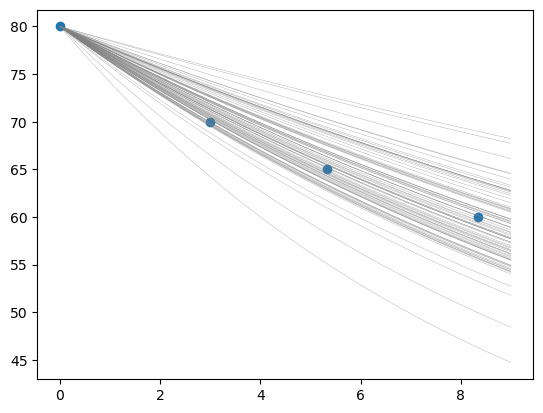

In [102]:
fig, ax = plt.subplots()

t_grid = np.linspace(0, 9, num=100)
betas = idata.posterior["beta"].values.flatten()[::50]
#alphas = idata.posterior["alpha"].values.flatten()[::50]
alphas = np.ones_like(betas) * np.log(80 - t_ambiente)

for alpha, beta in zip(alphas, betas):
    ax.plot(t_grid, np.exp(alpha - beta * t_grid) + t_ambiente, color="0.5", lw=0.2)

ax.scatter(tiempo, np.exp(y_stanley) + 24);

## Modelo jerárquico

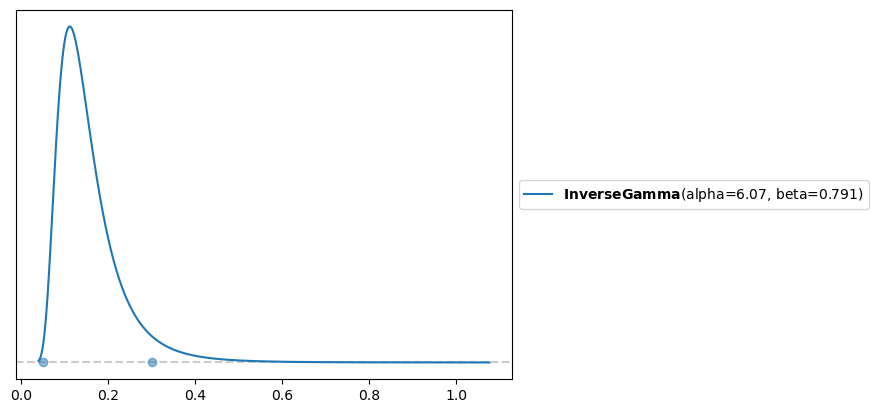

In [70]:
pz.maxent(pz.InverseGamma(), lower=0.05, upper=0.3, mass=0.95);

In [71]:
t_ambiente = 24
y = np.log(np.concatenate([temps for temps in datos.values()]) - t_ambiente)

In [72]:
marca_idx = np.repeat(np.arange(4), 4)
marca_idx

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [73]:
tiempos = np.tile(tiempo, 4)
tiempos

array([0.        , 3.        , 5.33333333, 8.33333333, 0.        ,
       3.        , 5.33333333, 8.33333333, 0.        , 3.        ,
       5.33333333, 8.33333333, 0.        , 3.        , 5.33333333,
       8.33333333])

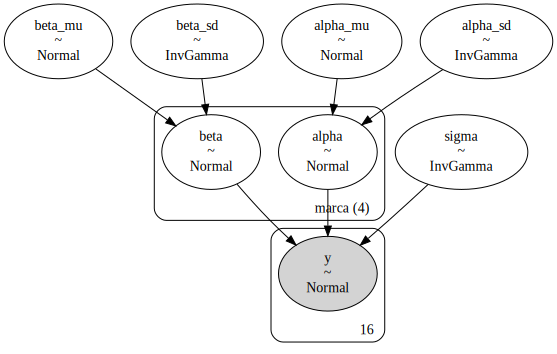

In [74]:
coords = {
    "marca": list(datos)
}


with pm.Model(coords=coords) as model:
    alpha_mu = pm.Normal("alpha_mu", mu=4, sigma=0.025)
    alpha_sd = pm.InverseGamma("alpha_sd", alpha=6, beta=0.8)
    alpha = pm.Normal("alpha", mu=alpha_mu, sigma=alpha_sd, dims="marca")

    beta_mu = pm.Normal("beta_mu", mu=0, sigma=0.1)
    beta_sd = pm.InverseGamma("beta_sd", alpha=6, beta=0.8)
    beta = pm.Normal("beta", mu=beta_mu, sigma=beta_sd, dims="marca")

    mu = alpha[marca_idx] - beta[marca_idx] * tiempos
    sigma = pm.InverseGamma("sigma", alpha=4.5, beta=0.8)

    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

model.to_graphviz()

In [75]:
with model:
    idata = pm.sample(target_accept=0.99, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_sd, alpha, beta_mu, beta_sd, beta, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


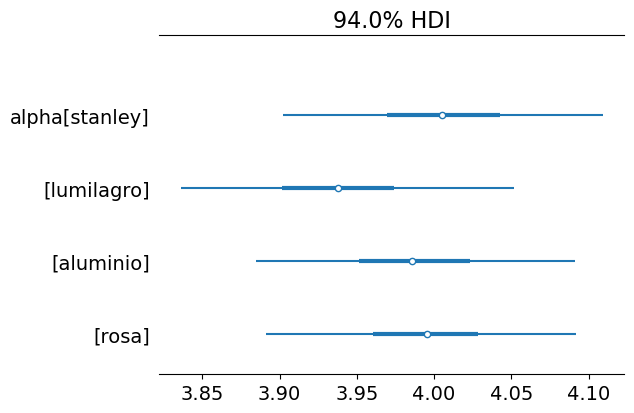

In [76]:
az.plot_forest(idata, var_names="alpha", combined=True);

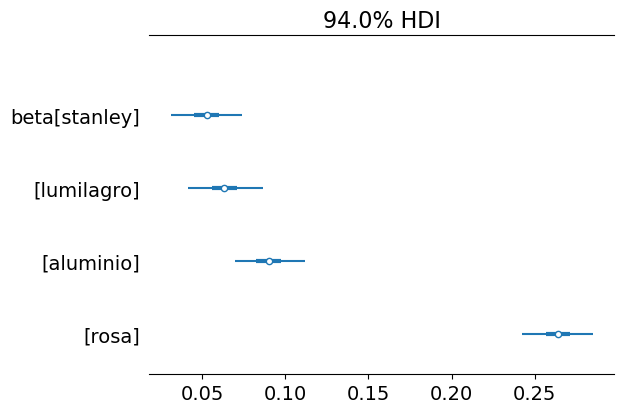

In [77]:
az.plot_forest(idata, var_names="beta", combined=True);

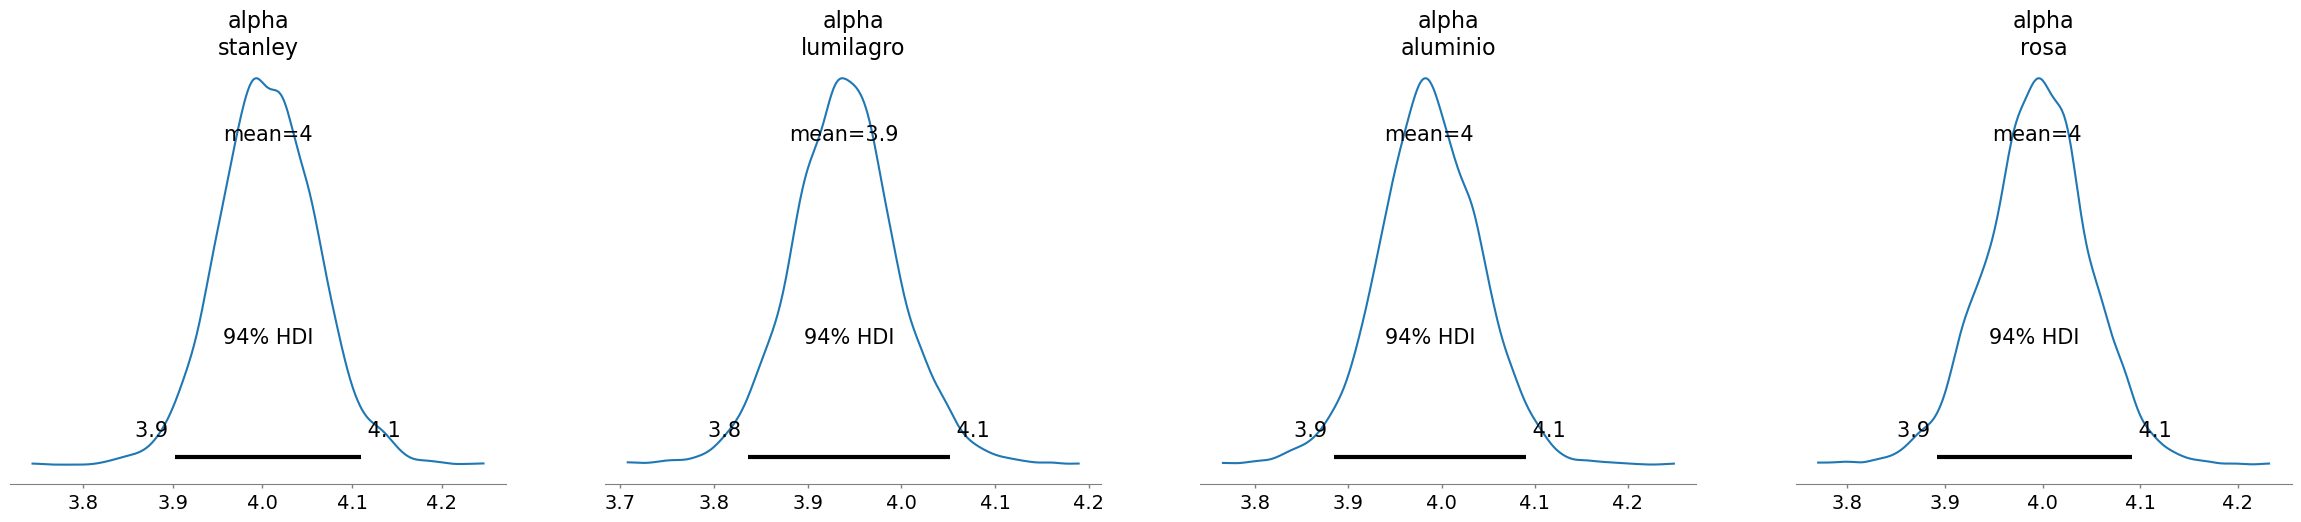

In [78]:
az.plot_posterior(idata, var_names="alpha");

In [79]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_mu,3.996,0.023,3.955,4.040,0.000,0.000,4673.0,2954.0,1.0
alpha[stanley],4.006,0.055,3.902,4.109,0.001,0.001,2754.0,2157.0,1.0
alpha[lumilagro],3.939,0.057,3.836,4.052,0.001,0.001,2524.0,2446.0,1.0
alpha[aluminio],3.987,0.055,3.885,4.091,0.001,0.001,2676.0,2384.0,1.0
alpha[rosa],3.994,0.054,3.891,4.092,0.001,0.001,2981.0,3054.0,1.0
beta_mu,0.082,0.057,-0.022,0.194,0.001,0.001,3568.0,2364.0,1.0
beta[stanley],0.053,0.012,0.031,0.074,0.000,0.000,2972.0,2376.0,1.0
beta[lumilagro],0.064,0.012,0.042,0.086,0.000,0.000,2833.0,2524.0,1.0
beta[aluminio],0.090,0.011,0.070,0.112,0.000,0.000,2639.0,2390.0,1.0
beta[rosa],0.264,0.011,0.243,0.285,0.000,0.000,3008.0,2599.0,1.0


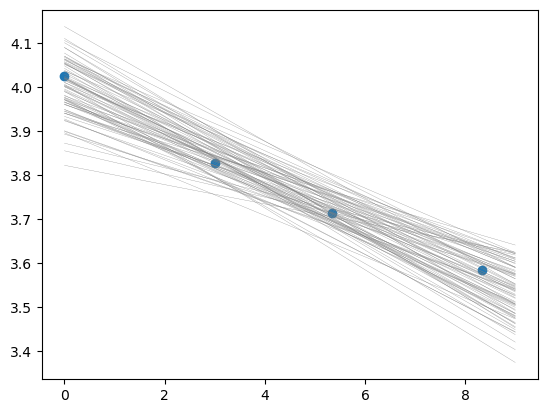

In [80]:
fig, ax = plt.subplots()

t_grid = np.linspace(0, 9, num=100)
betas = idata.posterior.sel(marca="stanley")["beta"].values.flatten()[::50]
alphas = idata.posterior.sel(marca="stanley")["alpha"].values.flatten()[::50]

for alpha, beta in zip(alphas, betas):
    ax.plot(t_grid, alpha - beta * t_grid, color="0.5", lw=0.2)

ax.scatter(tiempo, y_stanley);

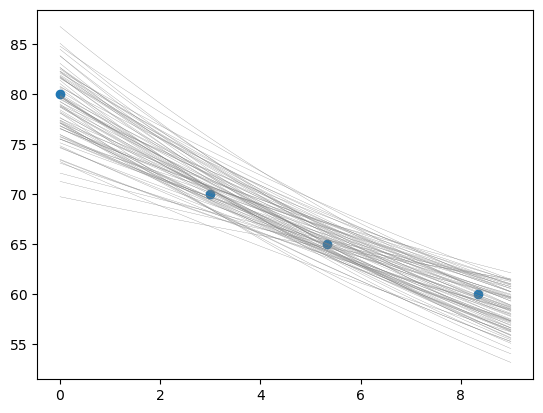

In [81]:
fig, ax = plt.subplots()

t_grid = np.linspace(0, 9, num=100)
betas = idata.posterior.sel(marca="stanley")["beta"].values.flatten()[::50]
alphas = idata.posterior.sel(marca="stanley")["alpha"].values.flatten()[::50]

for alpha, beta in zip(alphas, betas):
    ax.plot(t_grid, np.exp(alpha - beta * t_grid) + t_ambiente, color="0.5", lw=0.2)

ax.scatter(tiempo, np.exp(y_stanley) + t_ambiente);